Group: Krishna Havish Potharaju, Maggie Sun, Jack passyn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import pandas_datareader.data as web
from datetime import datetime

### Q1)

In [2]:
def normal_generator(mu,sig,sample_size,sim_size):
    x = np.random.normal(mu,sig**2,(sim_size,sample_size))
    e = np.random.normal(mu,sig**2,(sim_size,sample_size))
    yield x
    yield e

def monte_ols_beta(X,y):
    cov = np.mean(X*y,axis=1) - np.mean(X,axis=1)*np.mean(y,axis=1)
    var = np.var(X,axis=1)
    return cov/var

def plotter(plot_data,sample_sizes):
    num_plots = len(plot_data)
    fig, axes = plt.subplots(nrows=math.ceil(num_plots / 2), ncols=2, figsize=(15, 5 * math.ceil(num_plots / 2)))
    for i in range(num_plots):
        axes[i % 2][int(i/2)].title.set_text('Beta for size: ' + str(sample_sizes[i]))
        axes[i % 2][int(i/2)].hist(plot_data[i], bins = 70, density = True )
        axes[i % 2][int(i/2)].grid()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

sample_sizes = [20,50,100,500]
mu = 0
sig = 1
monte_carlo_size = 10000
gen_objects = [normal_generator(mu,sig,T,monte_carlo_size) for T in sample_sizes]
x = [next(gen_object) for gen_object in gen_objects]
e = [next(gen_object) for gen_object in gen_objects]

In [3]:
y = [sample_x+sample_e for (sample_x,sample_e) in zip(x,e)]
betas = [monte_ols_beta(sample_x,sample_y) for (sample_x,sample_y) in zip(x,y)]

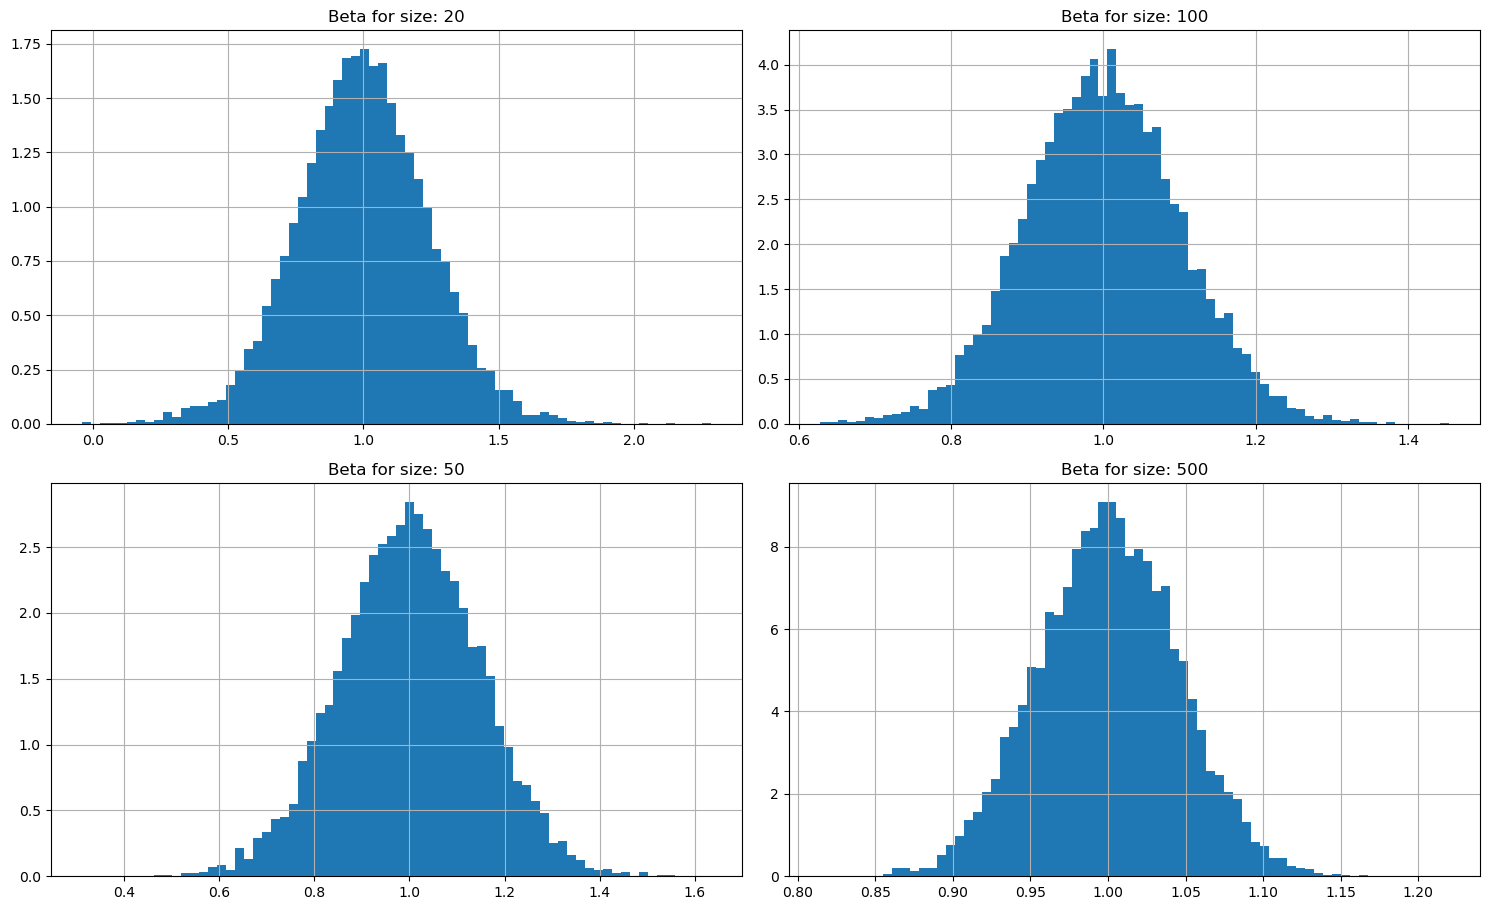

In [4]:
plotter(betas,sample_sizes)

### OLS assumptions and observations for the MC simulation
- Under the given simulation conditions on how we sample X,$\epsilon$, we can see that they are independent of each other $\implies$ strong exogenity
- As a result, classical OLS can be used to model the data and through monte carlo simulations, we can verify a bunch of BLUE assumptions like the unbiasedness and consistency of the $\hat{\beta}$ estimator\
- For unbiasedness, $\hat{\beta}$ should converge to true value(which is $1$ in this case). We can clearly see that the distributions of $\hat{\beta}$ are centered around $1$ with variance reducing
- As for the theoretical variance of the estimator, it is equal to $\sigma_{e}^2(X^TX)^{-1}$ which is given as $\frac{1}{\Sigma_{i=1}^{i=T}x^2}$ which would converge to $\frac{1}{T} \implies SE=\frac{1}{\sqrt{T}}$
- This also reflects in plots above as $T$ increases, we can see the distribution of $\hat{\beta}$ reduces and this implies consistency in the estimator as well
- Since observations and residuals are orthogonal, the predictions is the best linear estimator hence verifying the properties of BLUE

### Q2

In [5]:
class OLS_analysis():
    """OLS analysis helper functions"""
    def __init__(self, X,y):
        super(OLS_analysis, self).__init__()
        self.X = X
        self.y = y

    def fit(self,intercept=True):
        if intercept:
            X = np.column_stack([np.ones(self.X.shape[0]), self.X])
        else:
            X = self.X
        y = self.y
        Inv_matrix = np.linalg.inv(X.T.dot(X)) ### (X'X)^-1
        P = X.dot(Inv_matrix).dot(X.T)
        M = np.identity(X.shape[0]) - P
        self.OLS_estimate = P.dot(y)
        self.residuals = M.dot(y)
        self.beta = Inv_matrix.dot(X.T).dot(y)
        residual_variance = np.std(self.residuals)**2
        y_variance   = np.std(y)**2
        self.R_squared = 1 - residual_variance/y_variance
        self.OLS_Covar = Inv_matrix*residual_variance
        white_diagonals = np.diag(self.residuals.reshape(-1,)**2)
        mid_term = (X.T.dot(white_diagonals)).dot(X)
        self.white_Covar = (Inv_matrix.dot(mid_term)).dot(Inv_matrix)
        self.Inv_matrix = Inv_matrix
        self.X = X
        self.log_likelihood = -0.5*X.shape[0]*(np.log(2*np.pi) + 1 + np.log(residual_variance))
        
    def t_statistic(self,estim_index,true_val):
        return (self.beta[estim_index]-true_val)/np.sqrt(self.OLS_Covar[estim_index][estim_index])

    def newey_west(self, lag):
        residuals = self.residuals.flatten()
        n = self.X.shape[0]
        Inv_matrix = self.Inv_matrix
        S = np.zeros_like(Inv_matrix)
        for i in range(n):
            X_i = self.X[i, :].reshape(-1, 1)
            S += (X_i @ X_i.T) * residuals[i]**2
            
        for l in range(1, lag+1):
            weight = 1 - l / (lag + 1)
            for i in range(l, n):
                xi = self.X[i, :].reshape(-1, 1)
                xi_lag = self.X[i-l, :].reshape(-1, 1)
                S += weight * (xi @ xi_lag.T + xi_lag @ xi.T) * residuals[i] * residuals[i-l]
        var_beta_newey_west = Inv_matrix @ S @ Inv_matrix
        se_newey_west = np.sqrt(np.diag(var_beta_newey_west))
        return se_newey_west
            
    def AIC(self):
        return -2*self.log_likelihood + 2*(len(self.beta))

    def BIC(self):
        return -2*self.log_likelihood + (len(self.beta))*np.log(len(self.y))

def AR_estimate(pd_series,p,intercept = True):
    y = pd_series[p:].to_numpy()
    X = pd_series.to_numpy()
    X_AR = []
    for i in range(p):
        X_AR.append(pd_series.shift(i+1)[p:])
    X_AR = np.column_stack(X_AR) 
    y = y.reshape(-1,1)
    AR_estim = OLS_analysis(X_AR,y) ### Since AR is OLS with lags
    AR_estim.fit()
    return AR_estim

def acf_analysis(data):
    data = data - np.mean(data)
    AutoCorrel = np.correlate(data,data,mode = "full")/(len(data)*np.var(data)) ### Standardize to have correls wrt 1
    return AutoCorrel[len(AutoCorrel) // 2 :]

def pacf_analysis(data,max_lags):
    ### Regress against all lags and pickup the last coefficient
    pacfs = np.zeros(max_lags + 1)
    pacfs[0] = 1
    for lag in range(1, max_lags + 1):
        y = data[lag:]
        X = np.column_stack([data[lag-k-1:-k-1] for k in range(lag)])
        PACF_info = OLS_analysis(X,y)
        PACF_info.fit()
        pacfs[lag] = PACF_info.beta[-1]
    return pacfs

def IRF(phi,T):
    p = len(phi)
    h = np.zeros([T])
    h[0] = 1
    phi = phi.reshape(-1,)
    #phi = phi[::-1]
    for t in range(1,p):
        h[t] = np.dot(h[:t],phi[:t])
    for t in range(p, T):
        h[t] = np.dot(h[t-p:t],phi[::-1])
    return h

<Axes: xlabel='DATE'>

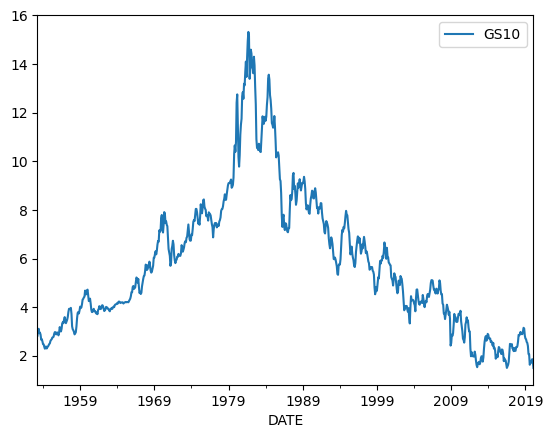

In [6]:
## start and end dates
start_date = datetime(1953, 4, 1)
end_date = datetime(2020, 2, 29)
## fetch time series
gs10_data = web.DataReader('GS10', 'fred', start_date, end_date)
gs10_data.head()
gs10_data.plot()

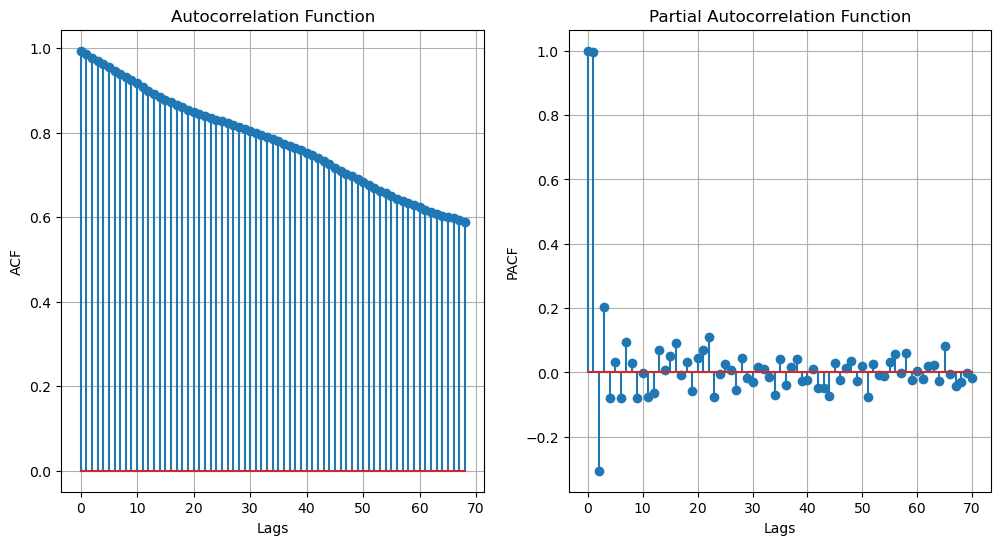

In [7]:
def acf_pacf_analysis(series):
    acf = acf_analysis(series.to_numpy())
    pacfs = pacf_analysis(series.to_numpy(),70)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    axes[0].set_title("Autocorrelation Function")
    axes[0].stem(acf[1:70])
    axes[0].grid()
    axes[0].set_xlabel("Lags")
    axes[0].set_ylabel("ACF")
    axes[1].set_title("Partial Autocorrelation Function")
    axes[1].stem(pacfs)
    axes[1].grid()
    axes[1].set_xlabel("Lags")
    axes[1].set_ylabel("PACF")

acf_pacf_analysis(gs10_data["GS10"])

### Preliminary breakdown
- Can see noticeable uptrend in first third of data and a downtrend with some seasonality involved in the GS$10$ time series as evident from the plot above
- The ACF function indicates a strong but steadily decaying autocorrelation as the number of lags increase
- The PACF on the other hand shows that the lags far ahead do not contribute as much to the autocorrelation in the data which indicates there is strong relationship between data points at 1st and 2nd lag
- Above may imply that its better to model this as either an AR(1) or an AR(2) process under stationarity assumption
- However, the slow decay does indicate non-stationarity / non-ergodic nature of the time series

In [8]:
AR1_estim = AR_estimate(gs10_data["GS10"],1) ## AR(1) process
AR2_estim = AR_estimate(gs10_data["GS10"],2) ## AR(2) process

### AR1 and AR2 parameters

In [9]:
print(f"Regression params for AR1 process are given as {AR1_estim.beta.flatten()}")
print(f"Regression params for AR2 process are given as {AR2_estim.beta.flatten()}")

Regression params for AR1 process are given as [0.01885719 0.99643801]
Regression params for AR2 process are given as [ 0.02700883  1.30063388 -0.30558521]


In [10]:
AR1_beta = AR1_estim.beta
AR1_roots = 1/AR1_beta[-1]
AR2_beta = AR2_estim.beta
AR2_roots = [2/(AR2_beta[1]+(AR2_beta[1]**2 + 4*AR2_beta[2])), 2/(AR2_beta[1]-(AR2_beta[1]**2 + 4*AR2_beta[2]))]
print("Roots of AR(1): ", AR1_roots)
print("Roots of AR(2): ", AR2_roots)

Roots of AR(1):  [1.00357472]
Roots of AR(2):  [array([1.12998085]), array([2.40579436])]


In [11]:
AR2_estim.newey_west(2)

array([0.02482315, 0.04446861, 0.04587071])

In [12]:
print(f"AR(1) AIC={AR1_estim.AIC()} and BIC = {AR1_estim.BIC()}")
print(f"AR(1) R_squared={AR1_estim.R_squared}")
print(f"AR(1) homoskedastic SE={np.sqrt(np.diag(AR1_estim.OLS_Covar)[-1])}, heteroskedastic SE={np.sqrt(np.diag(AR1_estim.white_Covar)[-1])}, Newey West SE={AR1_estim.newey_west(1)[1:]}")
print(f"AR(2) AIC={AR2_estim.AIC()} and BIC = {AR2_estim.BIC()}")
print(f"AR(2) R_squared={AR2_estim.R_squared}")
print(f"AR(2) homoskedastic SE={np.sqrt(np.diag(AR2_estim.OLS_Covar)[-1])}, heteroskedastic SE={np.sqrt(np.diag(AR2_estim.white_Covar)[-1])}, Newey West SE={AR2_estim.newey_west(2)[1:]}")

AR(1) AIC=149.38401497722273 and BIC = 158.75823219295577
AR(1) R_squared=0.9914464316121959
AR(1) homoskedastic SE=0.003268151203989519, heteroskedastic SE=0.005507808695452597, Newey West SE=[0.00617529]
AR(2) AIC=73.17682210968319 and BIC = 87.23440495088826
AR(2) R_squared=0.9922413640179439
AR(2) homoskedastic SE=0.03367394716572902, heteroskedastic SE=0.05467593484121261, Newey West SE=[0.04446861 0.04587071]


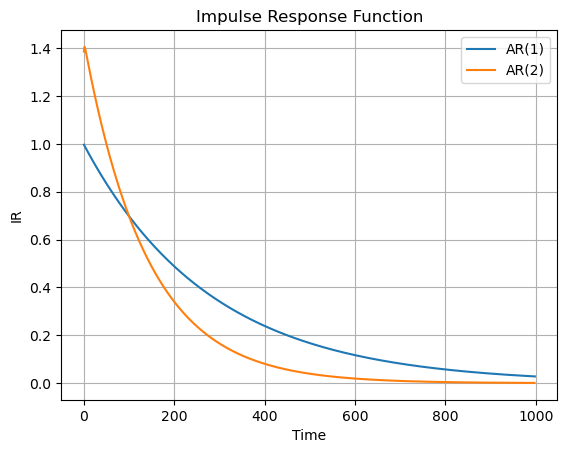

In [13]:
impulse_1 = IRF(AR1_beta[1:],1000)
impulse_2 = IRF(AR2_beta[1:],1000)
plt.title("Impulse Response Function")
plt.plot(impulse_1[1:], label = "AR(1)")
plt.plot(impulse_2[2:], label = "AR(2)")
plt.legend()
plt.xlabel("Time")
plt.ylabel("IR")
plt.grid()

### AR(1) vs AR(2)

Note that this comparison is being made under stationarity assumptions of the data as per the question. Following are few observations regarding the two AR processes:

- Regression statistics like AIC/BIC indicate that $AR(2)$ is better than $AR(1)$ albeit marginally in terms of representing the time series data
- We can also notice a high amount of R-2 implying under stationarity assumption, the variance is well explained
- Comparing the characteristic polynomial roots, we can see that $AR(2)$ is further away from the unit circle radius compared to $AR(1)$. This indicates that the $AR(2)$ is comparitively stable to forecast future data
- Impulse response also shows that as $T \to \infty$ the shock given at $T=0$ rapidly $\to 0$ for $AR(2)$

Hence, under stationarity assumptions, $AR(2)$ is a better choice of modelling this time series than $AR(1)$

### Q3)

In [14]:
def adf_test(series,maxlag=2): ### expects a time series and tests for stationarity
    diff_series = series.diff()[1:]
    y = diff_series[maxlag:].to_numpy() ### target variable is the difference series
    X = series.shift(1).to_numpy()[maxlag+1:] ### x_(t-1) series
    X_AR = [X]
    for i in range(maxlag):
        X_AR.append(diff_series.shift(i+1)[maxlag:])
    X_AR = np.column_stack(X_AR) 
    y = y.reshape(-1,1)
    AR_estim = OLS_analysis(X_AR,y) ### Regress vs x_(t-1) and all other lags
    AR_estim.fit()
    adf = AR_estim.t_statistic(1,0) ### interested in the first coefficient
    return adf
maxlag = 10
test = adf_test(gs10_data["GS10"],maxlag=10)
print(f"The ADF test statistic is for a lag of {maxlag} is given as:{test}")

The ADF test statistic is for a lag of 10 is given as:[-1.53601473]


In [15]:
import statsmodels.api as sm
adf_result = sm.tsa.adfuller(gs10_data["GS10"].to_numpy())[4] ### using this to get the critical value vs % mapping
print(f"Critical values for the augmented dickey fuller is: {adf_result}" )

Critical values for the augmented dickey fuller is: {'1%': -3.438750669890019, '5%': -2.8652477937238703, '10%': -2.56874438754281}


### Observations regarding stationarity
- Clearly by the Augmented Dickey Fuller test statistics and comparing to the critical value mapping above, we can't reject the Null that $\rho=0$ implying strong evidence of stationarity
- Few more points adding to this are the ACF function and the IRF function computed in the previous question. We can see that the IRF doesn't start to decay until we go past 200 lags and ACF function has non zero values towards the tail end
- Finally, the data itself shows a trend behavior in the ascent to maxima and the descent

In the below section, we try to see if any techniques like differencing/de-trending the data might help with removing the non-stationarity of the time series

In [16]:
## ADF test for the first difference series
test = adf_test(gs10_data["GS10"].diff()[1:],maxlag=10)
print(f"ADF for first difference series is {test}" )

ADF for first difference series is [-7.31164067]


We can see that the ADF statistic here is significantly lower than the critical values shown above implying the Null can be rejected $\implies$ The data is stationary and we can use AR(p) to model the time series

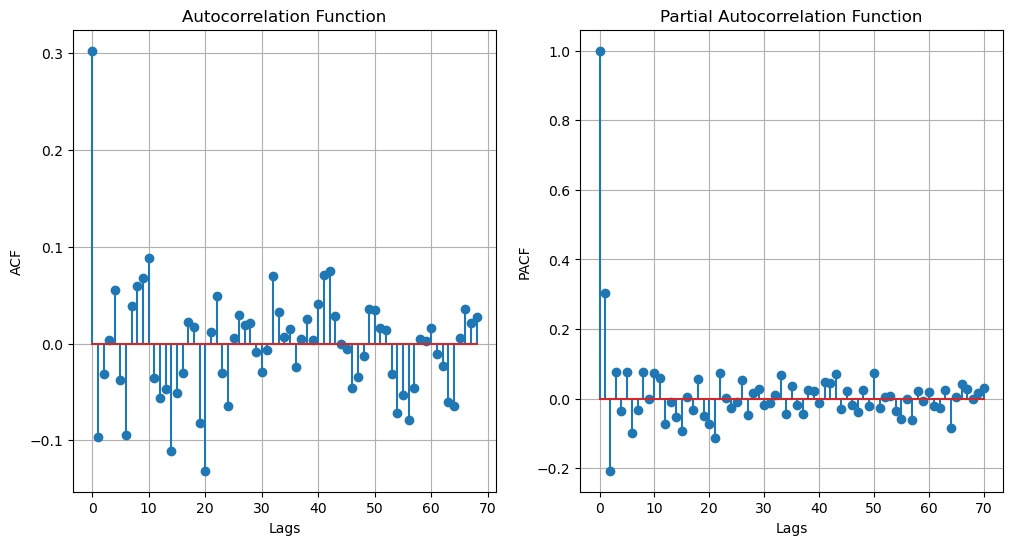

In [17]:
## Modelling the difference series as AR(p)
p_max = 10
models = []
for p in range(1,p_max+1):
    models.append(AR_estimate(gs10_data["GS10"].diff().dropna(),p))
AICs = [model.AIC() for model in models]
BICs = [model.BIC() for model in models]
R_squares = [model.R_squared for model in models]
acf_pacf_analysis(gs10_data["GS10"].diff().dropna())

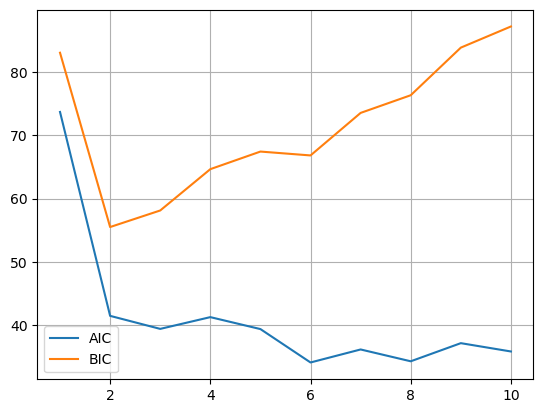

In [18]:
plt.plot(np.linspace(1,p_max,p_max), AICs, label = "AIC")
plt.plot(np.linspace(1,p_max,p_max), BICs, label = "BIC")
plt.legend()
plt.grid()
plt.show()

Seems like the highest dip is till lag of $2$ and post that the information criteria do not change drastically. Also we can see that ACF/PACF also drop off after first couple of lags. Hence AR($2$) on the first difference series is a better model which respects stationarity conditions

### Q4)

In [19]:
def return_AR(phi,m,n):
    p = len(phi)
    x = np.zeros([m,n])
    for i in range(p,n):
        x[:,i] = np.dot(x[:,i-p:i],phi).reshape(-1,) + np.random.normal(0,1,m) ### do the AR computation for x_t from coeffs and the white noise
    return x

In [20]:
from scipy.stats import t

def spurious_analysis(m,T,phi):
    y = return_AR([phi],m,T)
    x = return_AR([phi],m,T)
    regression_info = [OLS_analysis(x_sample,y_sample) for x_sample,y_sample in zip(x,y)]
    [info.fit() for info in regression_info]
    return regression_info

T = [200,1000]
phis = [0,0.9,1]
m = 10000
beta_summary = {}
t_stats_summary = {}
R2s_summary = {}
for t in T:
    for phi in phis:
        fits = spurious_analysis(m,t,phi)
        beta_summary[str(t)+","+str(phi)] = [fit.beta[-1] for fit in fits]
        t_stats_summary[str(t)+","+str(phi)] = [fit.t_statistic(-1,0) for fit in fits]
        R2s_summary[str(t)+","+str(phi)] = [fit.R_squared for fit in fits]

In [21]:
from scipy.stats import t
def t_test(t_val,dof,alpha):
    lower_bound = t.ppf(0.5*alpha, dof)
    upper_bound = t.ppf(1-0.5*alpha, dof)
    if not(lower_bound < t_val and t_val < upper_bound):
        return 1
    return 0

In [22]:
rejection_rate = {}
for key in t_stats_summary.keys():
    dof = int(key.split(",")[0]) - 2
    alphas = [0.01,0.05,0.1]
    rejections = []
    for alpha in alphas:
        rejections.append(np.mean([t_test(t_val,dof,alpha) for t_val in t_stats_summary[key]]))
    rejection_rate[key] = rejections

In [23]:
rejection_rate

{'200,0': [0.0119, 0.0513, 0.1028],
 '200,0.9': [0.404, 0.5254, 0.598],
 '200,1': [0.7782, 0.8343, 0.8614],
 '1000,0': [0.0103, 0.0486, 0.0964],
 '1000,0.9': [0.4067, 0.5267, 0.5939],
 '1000,1': [0.9012, 0.9243, 0.9369]}

In [24]:
def plotter_monte_summary(plot_data):
    num_plots = len(plot_data)
    fig, axes = plt.subplots(nrows=math.ceil(num_plots / 2), ncols=2, figsize=(15, 5 * math.ceil(num_plots / 2)))
    keys = list(plot_data.keys())
    print(axes.shape)
    for i in range(len(keys)):
        axes[int(i/2)][i%2].title.set_text(f"Sample size,phi of {keys[i]}")
        axes[int(i/2)][i%2].hist(plot_data[keys[i]], bins = 50, density = True )
        axes[int(i/2)][i%2].grid()
    plt.show()

### Betas across all $T,\phi$

(3, 2)


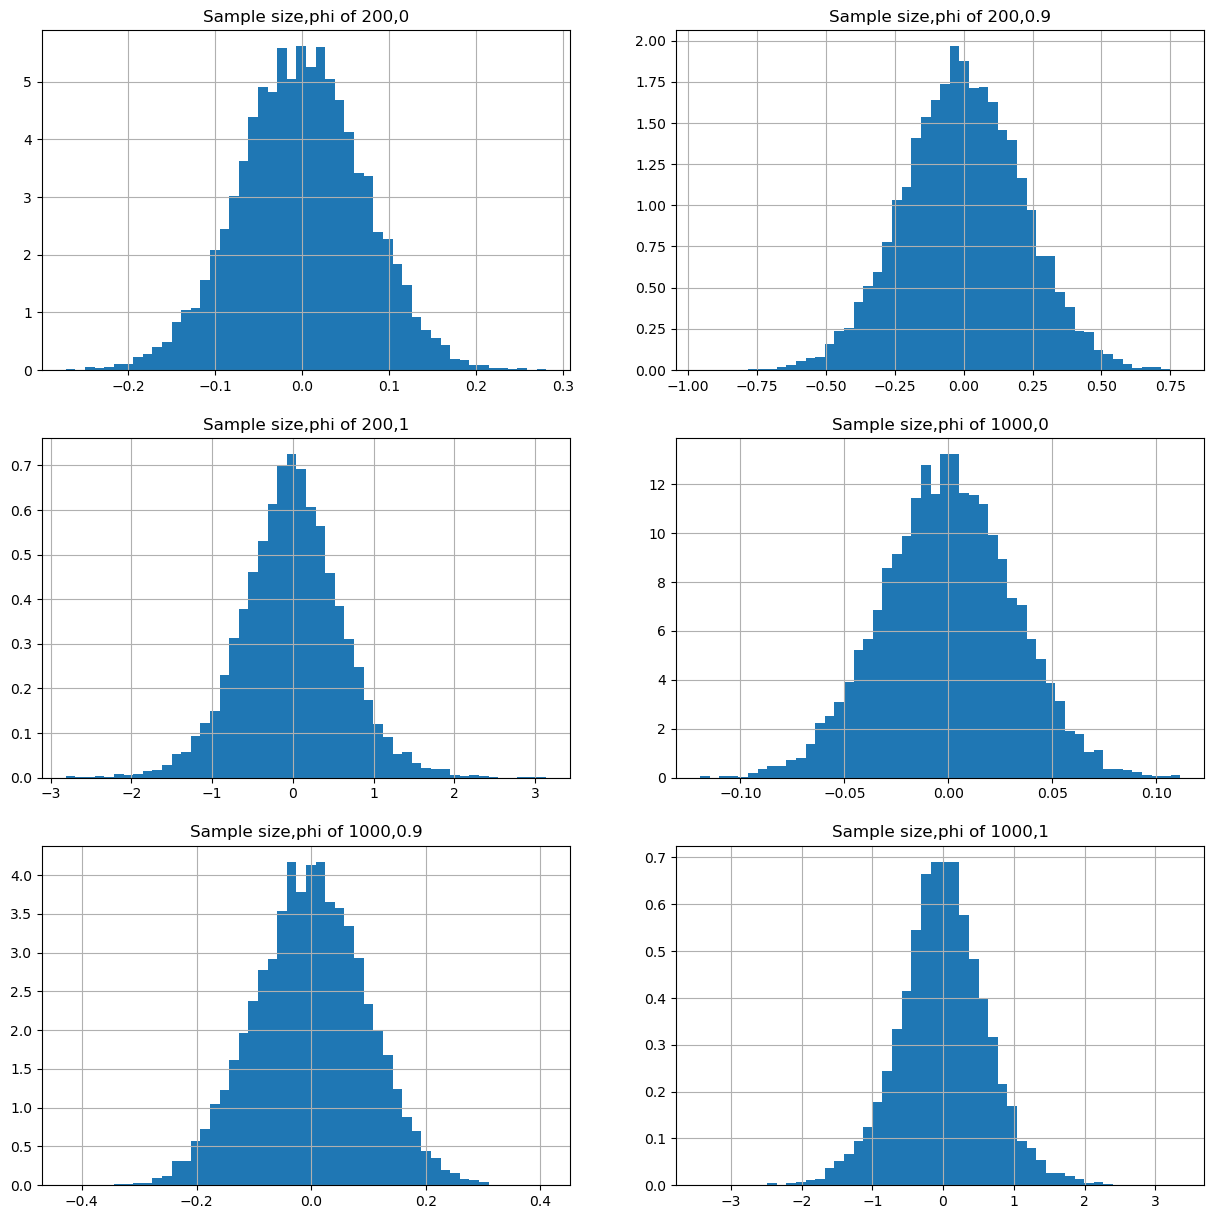

In [25]:
plotter_monte_summary(beta_summary)

### T-test histogram for T,$\phi$

(3, 2)


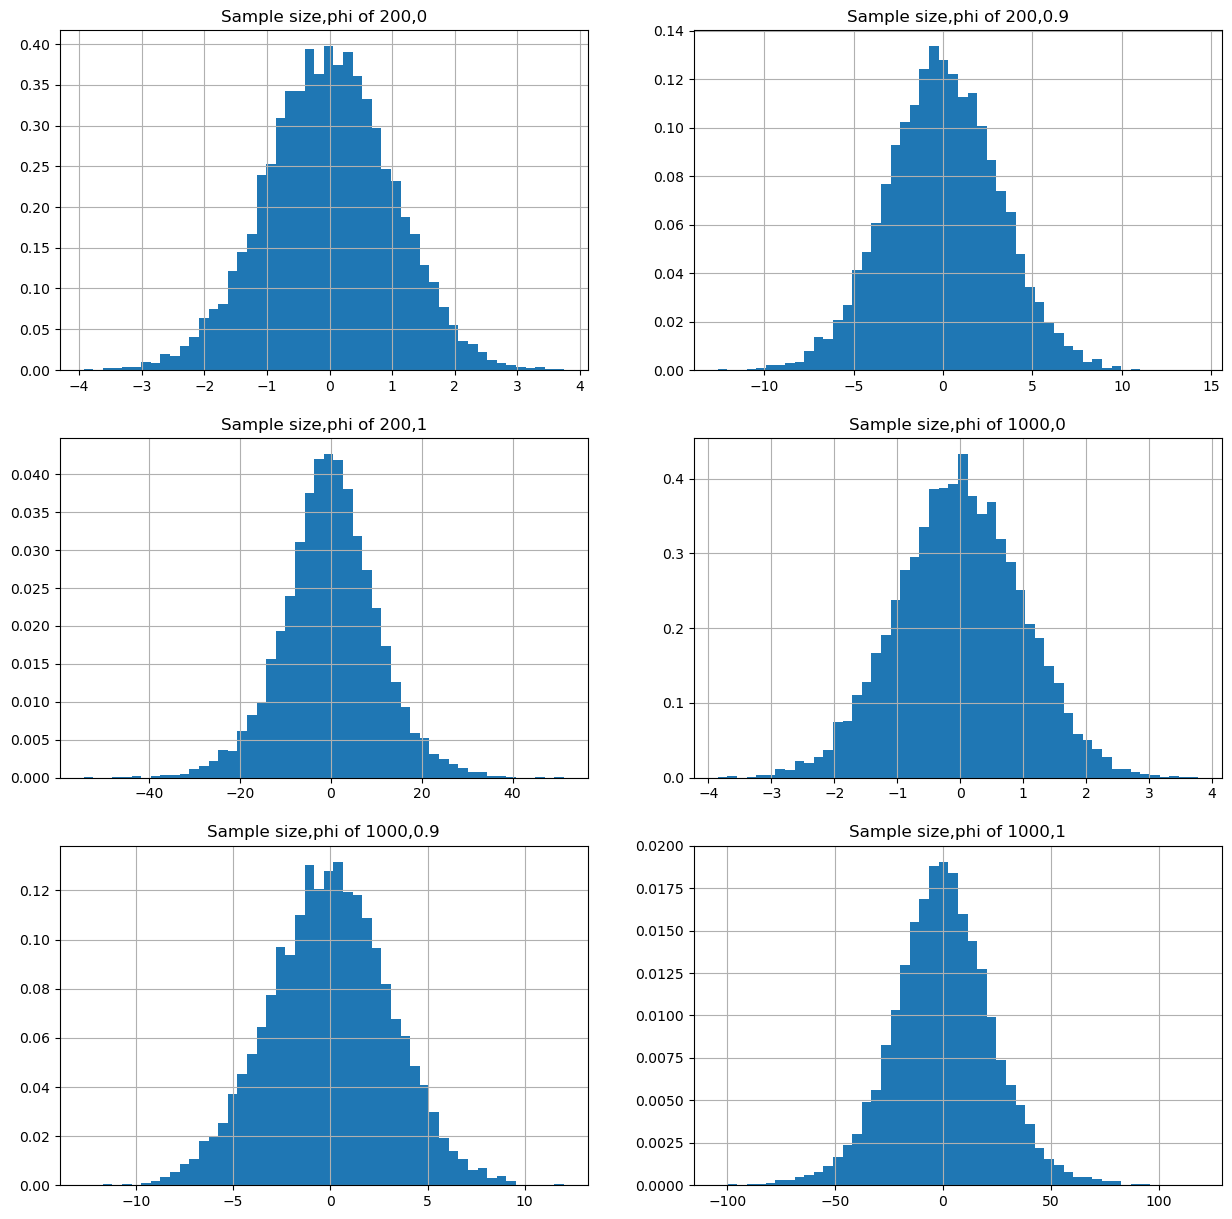

In [26]:
plotter_monte_summary(t_stats_summary)

### $R^2$ histogram for T,$\phi$

(3, 2)


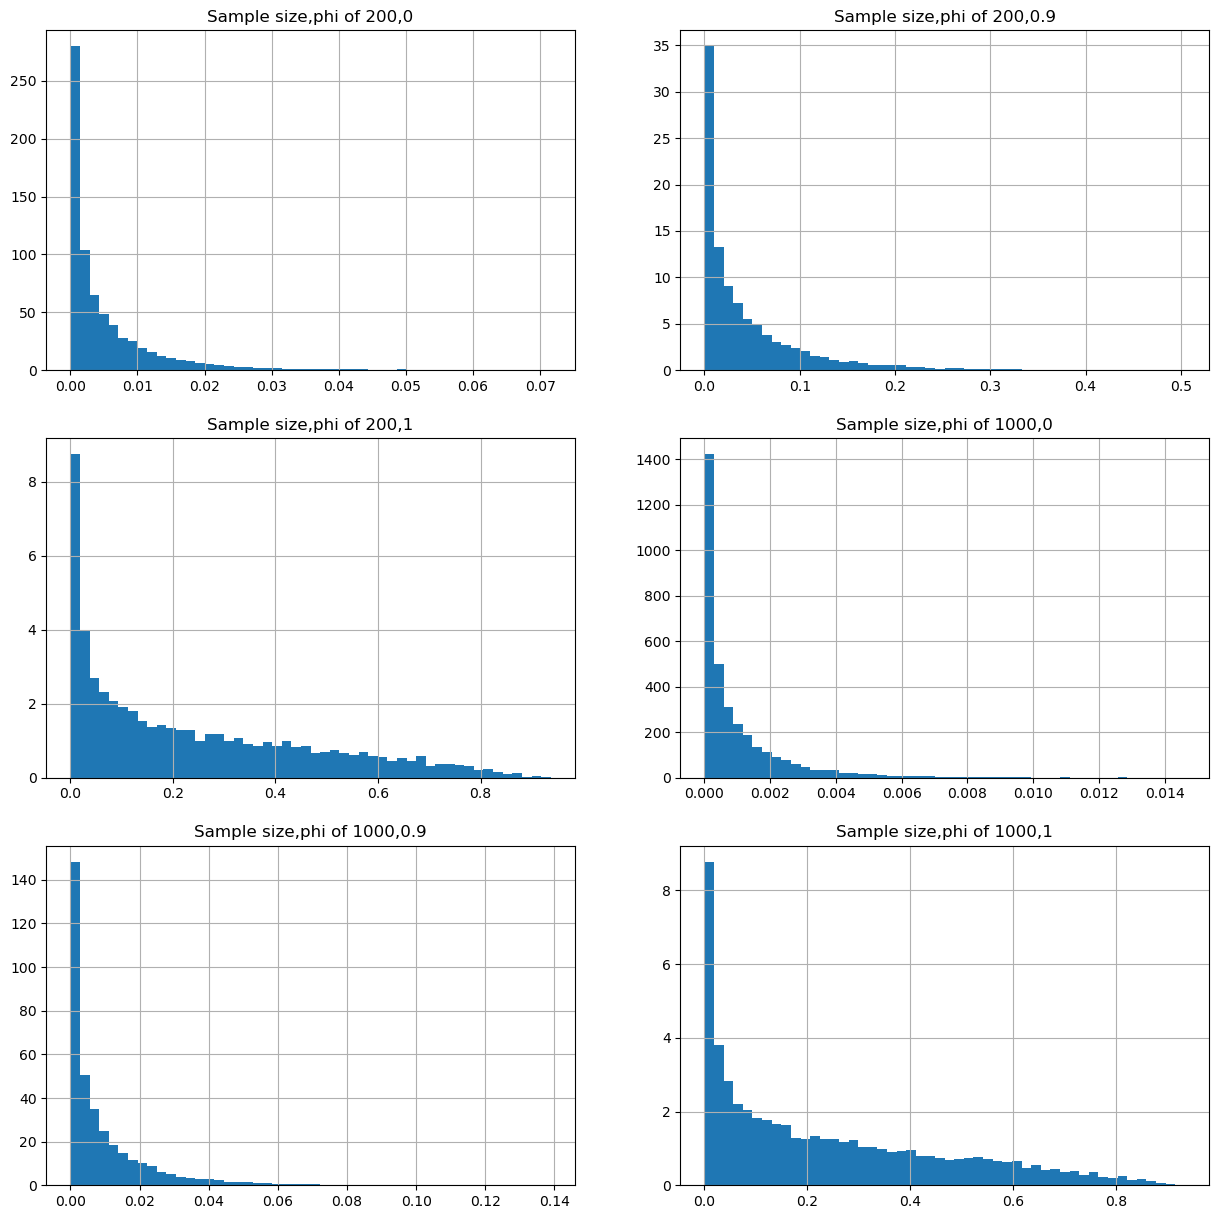

In [27]:
plotter_monte_summary(R2s_summary)

Few key observations to note:

- For smaller $\phi$, we can see some consistency as the standard errors are low and the estimated $\beta$'s are more compact
- However, interesting numbers to see are with the t-distribution and rejection rates. We can see that the t-distribution for $\phi = 1$ looks smoother than other values implying a well-defined t-stat. Also, the rejection rates of the Null hypothesis is quite high implying that for $\phi=1$ the regressor thinks there is some dependency between both the variables.
- A big sign for this being a fallacy is the wide range of values for estimated $\beta$(from the histogram of $\beta$'s) in the case of $\phi=1$. We can also see that $R^2$ is all over the place with few occasional $0.8/0.9$
- The theoretical rejection rates assuming no specific relationships should be similar to how the numbers were when we used $\phi = 0$ i.e., it should be same as the null hypothesis percentages
- One can also see that we fail to reject the Augmented dickey fuller Null hypothesis here implying that the residuals time series is nonstationary leading to the regression in fact being a bad relationship between the two variables